In [112]:
## Suppress warnings for a cleaner output
import warnings
warnings.filterwarnings('ignore')
# Core libraries for data processing and mathematical operations
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
# Deep learning libraries
import tensorflow as tf
import keras
from keras import layers
from keras.applications import VGG16
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D,BatchNormalization  # Layers for model customization
from tensorflow.keras.optimizers import Adam

## dataset download

In [113]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'eurosat',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [114]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

10


In [115]:
# Afficher les noms de classe
class_names = metadata.features['label'].names
print("Noms de classe :", class_names)

Noms de classe : ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


## Displaying Images

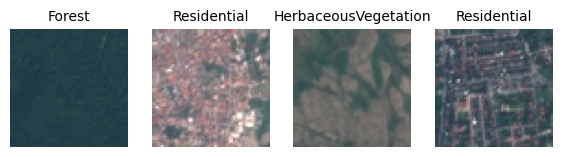

In [116]:
get_label_name = metadata.features['label'].int2str
train_iter = iter(train_ds)
fig = plt.figure(figsize=(7, 8))
for x in range(4):
  image, label = next(train_iter)
  fig.add_subplot(1, 4, x+1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(get_label_name(label),fontsize = 10) 

## Data augmentation

In [117]:
# Define image dimensions and batch size

IMG_SIZE = 64 # All images will be resized to 64x64

channels = 3 # 3 channels for RGB

BATCH_SIZE = 32 # Batch size of 32

def augment(image, label):
  image = tf.image.random_brightness(image, max_delta=0.5)
  image = tf.image.flip_left_right(image)
  image = tf.image.rot90(image)
  return image, label

def format_images(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/255) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) # Resize the image 

  return image, label

In [118]:
train_ds = train_ds.map(format_images)
validation_batches = val_ds.map(format_images).batch(BATCH_SIZE)
test_batches = test_ds.map(format_images).batch(BATCH_SIZE)

In [119]:
SHUFFLE_BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE

# With shuffle_buffer=1000 you will keep a buffer in memory of 1000 points.
# When you need a data point during training, you will draw the point randomly from points 1-1000.
# After that there is only 999 points left in the buffer and point 1001 is added.
# The next point can then be drawn from the buffer.

train_batches = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)


# Build a CNN model

In [24]:
model=keras.Sequential()

model.add(Conv2D(16,3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 batch_normalization_12 (Ba  (None, 62, 62, 16)        64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 31, 31, 16)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 31, 31, 16)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 batch_normalization_13 (Ba  (None, 29, 29, 32)       

In [25]:
epochs=10

history = model.fit(
  train_batches,
  validation_data=validation_batches,
  epochs=epochs
)

Epoch 1/10
675/675 [==============================] - 56s 82ms/step - loss: 1.1869 - accuracy: 0.5680 - val_loss: 1.8405 - val_accuracy: 0.4763
Epoch 2/10
675/675 [==============================] - 54s 80ms/step - loss: 0.8196 - accuracy: 0.7062 - val_loss: 0.9336 - val_accuracy: 0.6719
Epoch 3/10
675/675 [==============================] - 54s 80ms/step - loss: 0.7157 - accuracy: 0.7463 - val_loss: 1.4462 - val_accuracy: 0.5604
Epoch 4/10
675/675 [==============================] - 53s 79ms/step - loss: 0.6229 - accuracy: 0.7780 - val_loss: 1.7121 - val_accuracy: 0.5904
Epoch 5/10
675/675 [==============================] - 53s 79ms/step - loss: 0.5753 - accuracy: 0.7946 - val_loss: 0.8101 - val_accuracy: 0.7233
Epoch 6/10
675/675 [==============================] - 53s 79ms/step - loss: 0.5288 - accuracy: 0.8106 - val_loss: 1.0399 - val_accuracy: 0.6563
Epoch 7/10
675/675 [==============================] - 53s 79ms/step - loss: 0.4866 - accuracy: 0.8266 - val_loss: 1.2259 - val_accuracy:

### Pretrained VGG16 Model for feature selection

This code segment loads the VGG16 model pretrained on ImageNet and freezes its layers to prevent them from being updated during training.

- The `VGG16` model is loaded with pretrained weights from ImageNet using the `weights='imagenet'` parameter.
- The `include_top=False` parameter excludes the fully connected layers from the model.
- The `input_shape` parameter specifies the input image dimensions.
- All layers of the base model are iterated through, and their `trainable` attribute is set to `False` to freeze them.

In [120]:
# Load the VGG16 model, pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

#### Creating Custom Model on Top of Pretrained VGG16

In [121]:
# Create a custom model on top of the pretrained VGG16 model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [33]:
# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [34]:
history = model.fit(
    train_batches,
  validation_data=validation_batches,
    epochs=10
)

Epoch 1/10
675/675 [==============================] - 733s 1s/step - loss: 1.0396 - accuracy: 0.6431 - val_loss: 0.6762 - val_accuracy: 0.7826
Epoch 2/10
675/675 [==============================] - 731s 1s/step - loss: 0.6675 - accuracy: 0.7746 - val_loss: 0.5632 - val_accuracy: 0.8137
Epoch 3/10
675/675 [==============================] - 731s 1s/step - loss: 0.5677 - accuracy: 0.8085 - val_loss: 0.5172 - val_accuracy: 0.8263
Epoch 4/10
675/675 [==============================] - 730s 1s/step - loss: 0.5145 - accuracy: 0.8266 - val_loss: 0.4904 - val_accuracy: 0.8333
Epoch 5/10
675/675 [==============================] - 729s 1s/step - loss: 0.4722 - accuracy: 0.8396 - val_loss: 0.4702 - val_accuracy: 0.8415
Epoch 6/10
675/675 [==============================] - 736s 1s/step - loss: 0.4415 - accuracy: 0.8503 - val_loss: 0.4418 - val_accuracy: 0.8496
Epoch 7/10
675/675 [==============================] - 739s 1s/step - loss: 0.4194 - accuracy: 0.8577 - val_loss: 0.4411 - val_accuracy: 0.8463

## Model evaluation

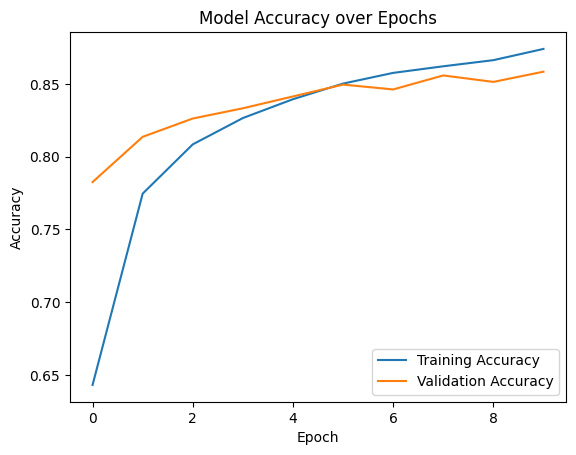

In [36]:
# Visualize model training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy over Epochs')
plt.show()

### Model Fine-Tuning

The provided code segment unfreezes the last 10 layers of the base model for fine-tuning. It then compiles the model with the following configurations:

In [ ]:
# Unfreeze the last 10 layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metric
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Continue training the model with fine-tuning
history_fine = model.fit(
    train_batches,
    validation_data=validation_batches,
    epochs=10
)

Epoch 1/10
470/675 [===================>..........] - ETA: 9:04 - loss: 1.7050 - accuracy: 0.3365

# Sample Test Images with Predicted Labels

In this code snippet, a sample of 8 test images along with their predicted labels are displayed using Matplotlib.

1/1 [==============================] - 0s 72ms/step


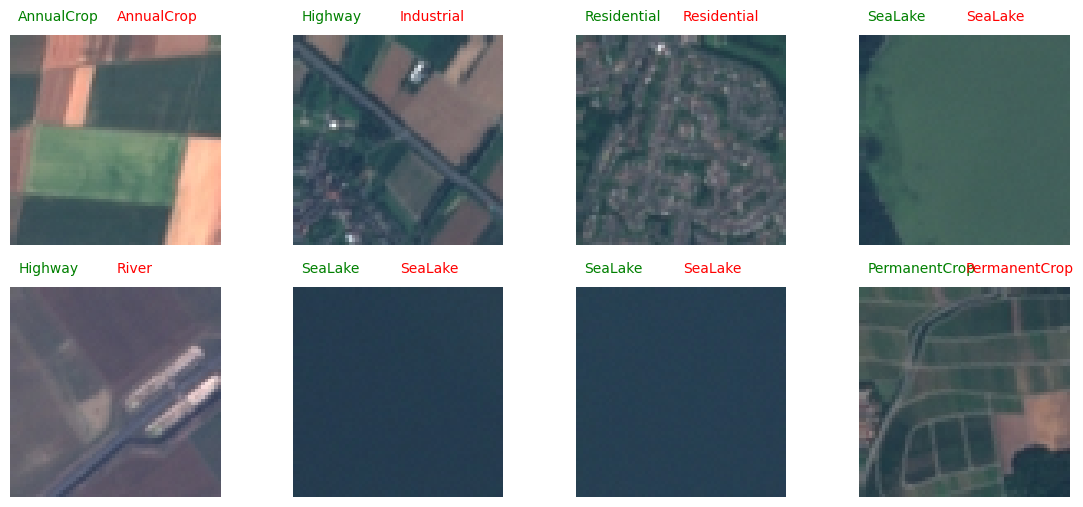

In [105]:
test_iter = iter(test_ds)
fig = plt.figure(figsize=(14, 6))
for x in range(8):
  image, label = next(test_iter)
  fig.add_subplot(2, 4, x+1)
  # Prédire l'étiquette avec le modèle CNN
  prediction = model.predict(tf.expand_dims(image, axis=0))
  predicted_label = np.argmax(prediction)

  plt.imshow(image)
  plt.axis('off')
  true_label = class_names[label.numpy()]
  predicted_class_name = class_names[predicted_label]
# display the True class in green
  plt.text(2, -5, true_label, fontsize=10, color="green")
# dispaly the predicted class in red
  plt.text(32, -5, predicted_class_name, fontsize=10, color="red")
